## Reviewer Comments Demonstration

In [1]:
## driftmlp is the package implementing this methodology
import driftmlp
## h3 to convert locations to their h3 indices.
## Where possible we use driftmlp.helpers.return_h3_inds()
import h3.api.basic_int as h3

## core python packages
import os
import numpy as np #
import pandas as pd
import pickle
import gc


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker

##Seaborn for plotting standard tabular data
import seaborn as sns

## Cartopy for map projections
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



rc('text', usetex=True)


## geopandas to aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon


import string
alphabet = string.ascii_lowercase


driftfile = os.environ['DRIFTFILE'] 


### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']

stations.loc[:,['Longitude', 'Latitude']].to_latex()
gc.collect()

0

## The cell below forms 5 networks:
- H3 Index resolution 3 and 4.
- Longitude, Latitude under a 0.5, 1 and 1.5 degree square grid size.

In [2]:
from driftmlp.drifter_indexing.discrete_system import h3_default, lon_lat_grid
drift_gen = driftmlp.driftiter.generator(driftfile, grid = [-90,27, -90,0])

discretizer_res3 = h3_default(res=3)
%time story_res3 = driftmlp.story.get_story(drift_gen(variables = ["position", "drogue"], drogue=True), discretizer=discretizer_res3)
discretizer_res4 = h3_default(res=4)
%time story_res4 = driftmlp.story.get_story(drift_gen(variables = ["position", "drogue"], drogue=True), discretizer = discretizer_res4)

story_and_dis = [(story_res3, discretizer_res3), (story_res4, discretizer_res4)]
for j in [0.5, 1, 1.5]:
    dis = lon_lat_grid(j)
    story = driftmlp.story.get_story(drift_gen(variables = ["position", "drogue"], drogue=True), discretizer=dis)
    story_and_dis.append((story, dis))
networks_tl5 = [driftmlp.form_network.make_transition(story) for story,_ in story_and_dis]

CPU times: user 34.4 s, sys: 436 ms, total: 34.8 s
Wall time: 34.8 s
CPU times: user 37.2 s, sys: 400 ms, total: 37.6 s
Wall time: 37.6 s
[True, True]
[True, True]
[True, True]


In [3]:
def add_gridlines(ax):
        gl = ax_current.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.right_labels = False
        gl.bottom_labels= False
        gl.xlines = False
        gl.xlocator = mticker.FixedLocator(list(range(-45,25,20)))#
        
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        #gl.xlabel_style = {'size': 15, 'color': 'gray'}
        #gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
        gl.ylocator = mticker.FixedLocator(list(range(-55,-10,10)))
        return gl

### For demonstration lets plot a collection of pathways from each method going from 1->3 and vice versa

We show pathways under the 5 grid sizes and for $\mathcal{T}_L \in \{2,5,10\}$

#### Figure S1 from the manuscript

/home/omalley3/Docs/DriftMLP/driftmlp/plotting/make_gpd.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df['centroid_col'] = geo_df.centroid


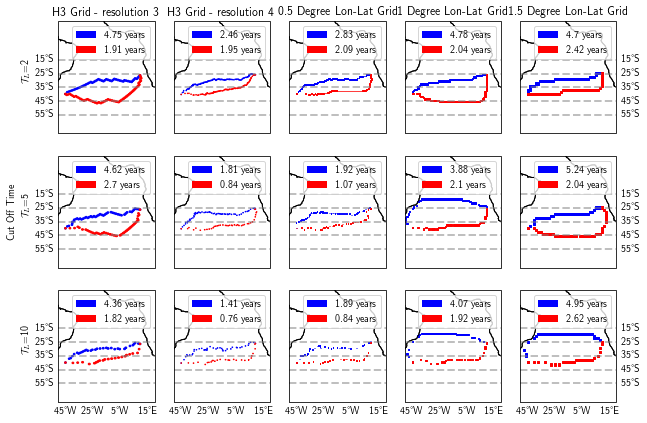

In [4]:
### from matplotlib.patches import Patch
fig, ax = plt.subplots(3, 5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[10,7])
loc1 = stations.iloc[0, [0,1]].to_list()
loc2 = stations.iloc[2, [0,1]].to_list()
titles = ["H3 Grid - resolution 3", "H3 Grid - resolution 4", "0.5 Degree Lon-Lat Grid", "1 Degree Lon-Lat Grid", "1.5 Degree Lon-Lat Grid" ]
#for T_L in range(5,10, 20)
sp_list_of_lists=[]


    
for ind, (story, discretizer) in enumerate(story_and_dis):
    sp_list=[]
    for row, cut_off in enumerate([2,5,10]):
        network = driftmlp.form_network.make_transition(story, day_cut_off=cut_off)
        sp = driftmlp.shortest_path.SingleSP(network, loc1, loc2, discretizer = discretizer)
        sp_list.append(sp)

        ax_current = ax[row, ind]
        ax_current.coastlines()                                                    
        sp.plot_cartopy(ax=ax_current)
        ax_current.set_extent([-50,20,-40,-10])
        if row==0:
            ax_current.set_title(f"{titles[ind]}")
        if ind==0:
            ax_current.text(-0.3, 0.55, '$\mathcal{T}_L$='+str(cut_off), va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax_current.transAxes)
        ax_current.legend(handles =[mpl.patches.Patch(facecolor="blue", label=f"{round(sp.sp.travel_time/365,2)} years"),
                           mpl.patches.Patch(facecolor="red", label=f"{round(sp.sp_rev.travel_time/365,2)} years")])
        gl = add_gridlines(ax_current)
        if row==2:
            gl.bottom_labels = True
        if ind==0:
            gl.left_labels = True
        elif ind==4:
            gl.right_labels = True
    sp_list_of_lists.append(sp_list)
fig.text(0.06, 0.5, 'Cut Off Time', ha='center', va='center', rotation='vertical')
fig.savefig(f"Images/grid_size_tt_results.pdf")

# The figure below is not used in the paper. 

## It just shows how pathways vary under bootstrap samples for various resolutions

/home/omalley3/Docs/DriftMLP/driftmlp/plotting/make_gpd.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df['centroid_col'] = geo_df.centroid


5
5
5
5


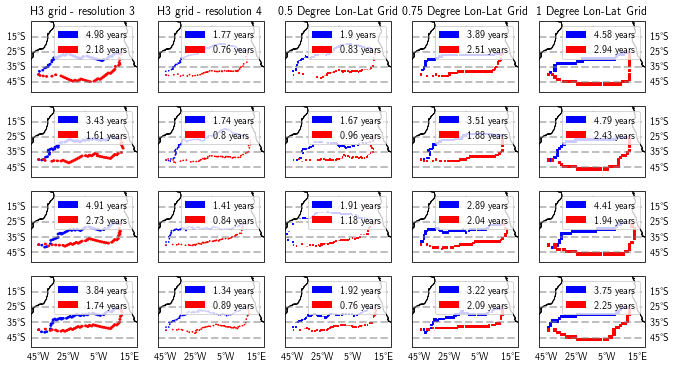

In [5]:
fig, ax = plt.subplots(4,5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[11,6])
loc1 = stations.iloc[0, [0,1]].to_list()
loc2 = stations.iloc[2, [0,1]].to_list()
titles = ["H3 grid - resolution 3", "H3 grid - resolution 4", "0.5 Degree Lon-Lat Grid", "0.75 Degree Lon-Lat Grid", "1 Degree Lon-Lat Grid" ]
#for T_L in range(5,10, 20)
bootsp_list_of_lists = []
bootnetworks_list_of_lists = []
story_len = len(story_and_dis[0][0])
day_cut_off=5
tt_array = np.zeros((5,4,2))
assert all([len(story)==story_len for story,_ in story_and_dis])

##First Loop is over a bootstrap sample (rows)
for row in range(4):
    boot_inds = np.random.randint(0, story_len, size=story_len)
    bootstrap_networks = []
    bootstrap_paths = []
    ## Second is over the grid system (columns)
    for ind, (story, discretizer) in enumerate(story_and_dis):
        boot_story = [story[i] for i in boot_inds]
        boot_network = driftmlp.form_network.make_transition(boot_story, day_cut_off=day_cut_off)
        
        sp = driftmlp.shortest_path.SingleSP(boot_network, loc1, loc2, discretizer = discretizer)
        tt_array[ind, row, 0] = sp.sp.travel_time
        tt_array[ind, row, 1] = sp.sp_rev.travel_time
        bootstrap_networks.append(boot_network)
        bootstrap_paths.append(sp)
        ax_current = ax[row, ind]
        ax_current.coastlines()
   
        sp.plot_cartopy(ax=ax_current)
        ax_current.set_extent([-50,20,-40,-10])
        if row==0:
            ax_current.set_title(f"{titles[ind]}")
        if ind==0:
            ax_current.set_ylabel(f"Sample {row}")
        ax_current.legend(handles =[mpl.patches.Patch(facecolor="blue", label=f"{round(sp.sp.travel_time/365,2)} years"),
                           mpl.patches.Patch(facecolor="red", label=f"{round(sp.sp_rev.travel_time/365,2)} years")])
        gl = add_gridlines(ax_current)
        if row==3:
            gl.bottom_labels = True
        if ind==0:
            gl.left_labels = True
        elif ind==4:
            gl.right_labels = True
    print(len(bootstrap_paths))
    bootsp_list_of_lists.append(bootstrap_paths)
    bootnetworks_list_of_lists.append(bootstrap_networks)


fig.savefig("Images/grid_size_boot_results.pdf")

In [6]:
bootsp_resfirst = [[bootsp_list_of_lists[i][j] for i in range(4)] for j in range(5)]
travel_times = []
travel_times_reverse = []
for bootsp_list, network in zip(bootsp_resfirst, networks_tl5): 
    t_sums=[]
    reverse_times =[]
    for boot_sp in bootsp_list:      
        boot_sp.sp.update_nid(network)
        t_sum = sum(boot_sp.sp.expected_days(network))
        boot_sp.sp_rev.update_nid(network)
        rev_time = sum(boot_sp.sp_rev.expected_days(network))
        reverse_times.append(rev_time)
        #try:
        #    sp_object.sp.update_nid(boot_network)
        #    
            
        #except:
        #    print("node doesn't exist in new network")
        #    t_sum=0
        t_sums.append(t_sum)
    travel_times.append(t_sums)      
    travel_times_reverse.append(reverse_times)
travel_times = np.array(travel_times)
travel_times_reverse = np.array(travel_times_reverse)

In [7]:
print("Travel time from bootstrap sample (row)")
display(tt_array[:,:,0])
print("Same path, non-bootstrapped network")
display(travel_times)
print("Difference")
display(travel_times_reverse-tt_array[:,:,0])

Travel time from bootstrap sample (row)


array([[1816.17493276, 1252.20661085, 1790.41407418, 1400.24770983],
       [ 646.74240785,  633.57677   ,  513.83228663,  488.78577159],
       [ 691.78421078,  610.11315128,  698.69228459,  700.76433903],
       [1420.58630645, 1281.8408242 , 1054.15975776, 1175.82755593],
       [1671.30381158, 1747.79562246, 1610.96162718, 1368.44166417]])

Same path, non-bootstrapped network


array([[2353.8452296 , 1562.35614174, 2291.80778974, 2256.81690359],
       [1078.61481082, 1023.79737842,  789.29495739,  700.48779094],
       [1005.64501319,  928.76069831,  917.21111866, 1007.91705004],
       [1700.35154887, 1750.2057539 , 1537.19593142, 1807.58205344],
       [2190.44736543, 2401.31624873, 2467.33833986, 1649.30181485]])

Difference


array([[-525.38472781, -359.16425424, -689.10748792, -668.74475901],
       [-255.61617137, -272.79646663, -187.35724852,   25.39492158],
       [-171.38028228, -156.21357768, -192.03306603, -302.2132857 ],
       [-221.06577475, -394.3014683 ,  -19.68417025, -252.79400729],
       [   7.65589758, -504.39985949, -842.5094555 , -485.04440783]])

In [8]:
print("Travel time from bootstrap sample (row)")
display((tt_array[:,:,1]/365))
print("Same path, non-bootstrapped network")
display((travel_times_reverse/365))
print("difference")
display((travel_times_reverse-tt_array[:,:,1])/365)

Travel time from bootstrap sample (row)


array([[2.17750785, 1.61254262, 2.73038929, 1.74454271],
       [0.76038813, 0.80442697, 0.84363253, 0.88924014],
       [0.83322859, 0.96377665, 1.17976332, 0.76452547],
       [2.5124289 , 1.87934178, 2.03986339, 2.09081124],
       [2.93536718, 2.43249976, 1.93818051, 2.25099786]])

Same path, non-bootstrapped network


array([[3.53641152, 2.44669139, 3.01727832, 2.00411767],
       [1.07157873, 0.98843919, 0.89445216, 1.40871423],
       [1.42576419, 1.24356048, 1.38810745, 1.09192069],
       [3.28635762, 2.43161467, 2.83417969, 2.52885904],
       [4.59988961, 3.40656373, 2.10534842, 2.42026646]])

difference


array([[1.35890367, 0.83414876, 0.28688903, 0.25957497],
       [0.3111906 , 0.18401222, 0.05081963, 0.51947409],
       [0.5925356 , 0.27978382, 0.20834412, 0.32739522],
       [0.77392872, 0.5522729 , 0.7943163 , 0.4380478 ],
       [1.66452243, 0.97406398, 0.16716791, 0.16926859]])

In [9]:
(story, discretizer), network =story_and_dis[1], network_tl5[1]
network = driftmlp.form_network.make_transition(story, day_cut_off=cut_off)

NameError: name 'network_tl5' is not defined

NameError: name 'p' is not defined

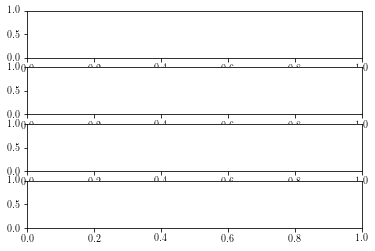

In [11]:
from multiprocessing import Pool
def make_network_get_sp(story, day_cut_off):
    boot_story = [story[i] for i in boot_inds]
    boot_network = driftmlp.form_network.make_transition(boot_story, day_cut_off=day_cut_off)    
    sp = DriftML
for ind, (story, discretizer) in enumerate(story_and_dis):
    sp_list=[]
    for row, cut_off in enumerate([2,5,10]):
        bootstrap_paths = []
        fig, ax = plt.subplots(4,1)
        sps = p.map(make_network_get_sp())
        ax[row]
        tt_array[ind, row, 0] = sp.sp.travel_time
        tt_array[ind, row, 1] = sp.sp_rev.travel_time
        bootstrap_networks.append(boot_network)
        bootstrap_paths.append(sp)
        ax_current = ax[row, ind]
        ax_current.coastlines()
   
        sp.plot_cartopy(ax=ax_current)
        ax_current.set_extent([-50,20,-40,-10])
        if row==0:
            ax_current.set_title(f"{titles[ind]}")
        if ind==0:
            ax_current.set_ylabel(f"Sample {row}")
        ax_current.legend(handles =[Patch(facecolor="blue", label=f"{round(sp.sp.travel_time/365,2)} years"),
                           Patch(facecolor="red", label=f"{round(sp.sp_rev.travel_time/365,2)} years")])
        gl = add_gridlines(ax_current)
        if row==3:
            gl.bottom_labels = True
        if ind==0:
            gl.left_labels = True
        elif ind==4:
            gl.right_labels = True
    print(len(bootstrap_paths))
    bootsp_list_of_lists.append(bootstrap_paths)
    bootnetworks_list_of_lists.append(bootstrap_networks)